## Controlled Experiments

Here, we design a controlled experiment to better understand the capabilities of DANA, compared to other available solutions. We generate a synthetic five-class dataset that simulates two motion sensors in a way that we can adjust the correlation between patterns observed in two sensors. Thus, we provide evaluations in three different settings of correlation: low, moderate, and high correlation.

> See Section 6 in the paper for more details: https://arxiv.org/pdf/2008.02397.pdf

In [1]:
!pip install tensorflow==2.3.0

1. In case that you are running this in your own Gdrive, use the following commands to save the resulrs in your derive.

In [2]:
from google.colab import drive
drive.mount('/content/gdrive/', force_remount= True)

Mounted at /content/gdrive/


In [3]:
cd gdrive/My\ Drive/Colab\ Notebooks

/content/gdrive/My Drive/Colab Notebooks


2. Import required moduls.

In [4]:
import sys
sys.path.append(".")
import numpy as np
import matplotlib.pyplot as plt
from sklearn.utils import class_weight
from sklearn.metrics import confusion_matrix

import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras import regularizers
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model
print("TensorFlow Version: ", tf.__version__)

TensorFlow Version:  2.3.0


3. Set up the experiments. If you run this more than once, set a different `rnd_seed` and add it to the `rnd_seeds` (e.g. if you run this three times with different random seeds 1,2, and 3, then set `rnd_seeds = [1,2,3]`). This helps you get the proper results plotted at the end.

In [5]:
exp_type = 1
num_epochs = 500
rnd_seed = 1
rnd_seeds = [1]
num_of_exps = 1
tf.random.set_seed(rnd_seed)
np.random.seed(rnd_seed)

In [6]:
## Keep this fixed, unless you want to play with the synthetic dataset.
n_classes = 5
dim = 50
rhos = [0.01, 0.57423, .89336]
batch_size = 3
means = [0., 0., 0., 0., 0.]
stddevs = [.6, .7, .8, .9, 1.]

## Synthetic Dataset

In [7]:
from numpy import pi
def moving_average(x, w):
    return np.convolve(x, np.ones(w), 'same') / w

def sample_correlated_gaussian(rho=0.5, dim=128, batch_size=3, mean=0.0, stddev=1.0, class_id=-1, train=True):
    """Generate samples from a correlated Gaussian distribution."""
    x, eps = tf.split(tf.random.normal((batch_size, 2 * dim), mean=mean, stddev=stddev), 2, axis=1)
    y = rho * x + tf.sqrt(tf.cast(1. - rho**2, tf.float32)) * eps     
    x, y = x.numpy(), y.numpy()                                   

    t = np.arange(0,dim)
    trends = [  0.*t,
                0.002 * (t - dim//2)**2-.5,
                0.001 * (t - dim//4)**2-.5,
                1-0.002 * (t - dim//2)**2-.5,                
                1-0.001 * (t - dim//4)**2-.5
             ]
    preiods = [   np.sin(2*pi*t/5)*.7,
                  np.sin(2*pi*t/10)*.7,
                  np.sin(2*pi*t/15)*.7,
                  np.sin(2*pi*t/20)*.7,
                  np.sin(2*pi*t/25)*.7,               
                  np.sin(2*pi*t/30)*.7,
                  np.sin(2*pi*t/35)*.7
              ]
    
    if class_id >= 0:
        for i in range(len(x)):            
            if rho > .8:
                noise = (tf.random.normal((1, dim), mean=0., stddev=mean+stddev/((i+class_id)%3+2)))[0].numpy()
                x[i] += noise
                y[i] += noise                                  
                x[i] = moving_average(x[i], (i+class_id)%3+1)
                y[i] = moving_average(y[i], (i+class_id)%3+1)
                x[i] += trends[(class_id)%5]
                y[i] += trends[(class_id)%5]
                x[i] += preiods[(class_id)%5]+ preiods[(class_id+2)%5]+preiods[(class_id+3)%5]
                y[i] += preiods[(class_id)%5]+ preiods[(class_id+2)%5]+preiods[(class_id+5)%5]            
                if not train:
                    noise = (tf.random.normal((1, dim), mean=0., stddev=.25))[0].numpy()
                    x[i] += noise
                    noise = (tf.random.normal((1, dim), mean=0., stddev=.3))[0].numpy()
                    y[i] += noise                                  
                    
            elif rho > .4:
                noise = (tf.random.normal((1, dim), mean=0., stddev=mean+stddev/((i+class_id)%3+2)))[0].numpy()
                x[i] += noise
                y[i] += noise                                  
                x[i] = moving_average(x[i], (i+class_id)%3+1)
                y[i] = moving_average(y[i], (i+class_id)%3+1)
                x[i] += trends[(class_id)%5]
                y[i] += trends[(class_id+1)%5]
                x[i] += preiods[(class_id)%5]+ preiods[(class_id+2)%5]+preiods[(class_id+3)%5]
                y[i] += preiods[(class_id)%5]+ preiods[(class_id+1)%5]+preiods[(class_id+5)%5]            
                if not train:
                    noise = (tf.random.normal((1, dim), mean=0., stddev=.3))[0].numpy()
                    x[i] += noise
                    noise = (tf.random.normal((1, dim), mean=0., stddev=.3))[0].numpy()
                    y[i] += noise                                  
                
            else:
                noise = (tf.random.normal((1, dim), mean=0., stddev=mean+stddev/((i+class_id)%3+2)))[0].numpy()
                x[i] += noise
                noise = (tf.random.normal((1, dim), mean=0., stddev=mean+stddev/((i+class_id)%3+2)))[0].numpy()
                y[i] += noise
                x[i] = moving_average(x[i], (i+class_id)%3+1)
                y[i] = moving_average(y[i], (i+class_id)%3+1)
                x[i] += trends[(class_id)%5]
                y[i] += trends[(class_id+3)%5]
                x[i] += preiods[(class_id)%5]+ preiods[(class_id+1)%5]+preiods[(class_id+2)%5]
                y[i] += preiods[(class_id+3)%5]+ preiods[(class_id+4)%5]+preiods[(class_id+5)%5]
                if not train:
                    noise = (tf.random.normal((1, dim), mean=0., stddev=.3))[0].numpy()
                    x[i] += noise
                    noise = (tf.random.normal((1, dim), mean=0., stddev=.3))[0].numpy()
                    y[i] += noise                                  
              
                
    return x, y

def rho_to_mi(dim, rho):
    return -0.5  * np.log(1-rho**2) * dim

def mi_to_rho(dim, mi):
    return np.sqrt(1-np.exp(-2.0 / dim * mi))

In [8]:
def generate_dataset(k, n, train=True):
    X, Y = [], []
    for i in range(n):
        class_id = tf.random.categorical([[1/n_classes]*n_classes], 1)[0][0].numpy()
        s1, s2 = sample_correlated_gaussian(batch_size=3, dim=dim, rho=rhos[k], 
                                            mean=means[class_id], stddev=stddevs[class_id],
                                            class_id=class_id, train=train
                                           )
        s1, s2 = s1.T, s2.T
        tw = np.append(s1,s2,axis=1)
        X.append(tw.tolist())
        Y.append(class_id)
    X = np.array(X)
    Y = np.array(Y)
    return X.copy(), Y.copy()

X_train , Y_train = generate_dataset(exp_type, 4000, train=True)
X_test , Y_test = generate_dataset(exp_type, 1000, train=False)

# np.unique(Y_train, return_counts=True)[1].tolist(), np.unique(Y_test, return_counts=True)[1].tolist()
print(X_train.shape, Y_train.shape, X_test.shape, Y_test.shape)

data_class_weights = class_weight.compute_class_weight('balanced',range(n_classes),Y_train)
data_class_weights = dict(zip(range(len(data_class_weights)),data_class_weights.round(2)))
data_class_weights

(4000, 50, 6) (4000,) (1000, 50, 6) (1000,)


{0: 0.96, 1: 0.97, 2: 1.03, 3: 1.04, 4: 0.99}

## Original DNN

In [9]:
def Ordonez2016DeepOriginal(inp_shape, out_shape):   
    """
    @article{ordonez2016deep,
        title={Deep convolutional and {LSTM} recurrent neural networks for multimodal wearable activity recognition},
        author={Ord{\'o}{\~n}ez, Francisco and Roggen, Daniel},
        journal={Sensors},
        volume={16},
        number={1},
        pages={115},
        year={2016},
        publisher={Multidisciplinary Digital Publishing Institute}
    }
    """   
    nb_filters = 10 
    drp_out_dns = .5 
    nb_dense = 5 
    
    inp = Input(inp_shape)
    x = Conv2D(nb_filters, kernel_size = (5,1),
              strides=(1,1), padding='valid', activation='relu')(inp)
    x = Conv2D(nb_filters, kernel_size = (5,1),
              strides=(1,1), padding='valid', activation='relu')(x)
    x = Reshape((x.shape[1],x.shape[2]*x.shape[3]))(x)
    act = LSTM(nb_dense, return_sequences=False, activation='tanh', name="lstm_1")(x)        
    act = Dropout(drp_out_dns, name= "dot_1")(act)
    out_act = Dense(out_shape, activation='softmax',  name="act_smx")(act)
    model = keras.models.Model(inputs=inp, outputs=out_act)
    return model
X_train = np.expand_dims(X_train,3)
X_test = np.expand_dims(X_test,3)

w = X_train.shape[1]
h = X_train.shape[2]
org_model = Ordonez2016DeepOriginal((w, h, 1), len(np.unique(Y_train)))
org_model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 50, 6, 1)]        0         
_________________________________________________________________
conv2d (Conv2D)              (None, 46, 6, 10)         60        
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 42, 6, 10)         510       
_________________________________________________________________
reshape (Reshape)            (None, 42, 60)            0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 5)                 1320      
_________________________________________________________________
dot_1 (Dropout)              (None, 5)                 0         
_________________________________________________________________
act_smx (Dense)              (None, 5)                

In [10]:
def standard_training(model, X_train, Y_train, X_val, Y_val, data_class_weights,
                      batch_size=128, num_epochs=128, save_dir=None):
    loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False)
    optimizer = tf.keras.optimizers.Adam()
    best_val_accuracy = 0.
    for epoch in range(num_epochs):  

        ## Training
        train_dataset = tf.data.Dataset.from_tensor_slices((X_train, Y_train))
        train_dataset = iter(train_dataset.shuffle(len(X_train)).batch(batch_size))
        n_iterations_per_epoch = len(X_train)//(batch_size)
        epoch_loss_avg = tf.keras.metrics.Mean()           
        for i in range(n_iterations_per_epoch):                
            with tf.GradientTape() as tape:
                X, Y = next(train_dataset)
                sample_weight = [data_class_weights[y] for y in Y.numpy()]                        
                logits = model(X)               
                loss_value = loss_fn(Y, logits, sample_weight)
            gradients = tape.gradient(loss_value, model.trainable_weights)
            optimizer.apply_gradients(zip(gradients, model.trainable_weights))                        
            epoch_loss_avg.update_state(loss_value)

        ## Validation
        val_accuracy = tf.keras.metrics.Accuracy()
        logits = model(X_val, training=False)
        prediction = tf.argmax(logits, axis=1, output_type=tf.int32)
        val_accuracy(prediction, Y_val)
        current_val_acc = val_accuracy.result()
        
        if current_val_acc > best_val_accuracy:
            best_val_accuracy = current_val_acc
            if save_dir:
                model.save_weights(save_dir)

        print ("Epoch {} -- Training Loss = {:.4f} -- Validation Accuracy {:.4f}".format(
            epoch,
            epoch_loss_avg.result(),
            current_val_acc))
    
    if save_dir:
        model.load_weights(save_dir)
    print("Best Validation Accuracy {:.4f}".format(best_val_accuracy))
    print("Training Finished! \n------------------\n")
    return model

org_model = standard_training(org_model, 
                  X_train[len(X_train)//10:], Y_train[len(X_train)//10:],
                  X_train[:len(X_train)//10], Y_train[:len(X_train)//10],
                  data_class_weights,
                  batch_size=128, num_epochs=num_epochs,
                  save_dir = "saved_models/standard/"+str(rnd_seed)+"/Ordonez2016DeepOriginal")

## Testing
test_accuracy = tf.keras.metrics.Accuracy()
logits = org_model(X_test, training=False)
prediction = tf.argmax(logits, axis=1, output_type=tf.int32)
test_accuracy(prediction, Y_test)
print("Test Accuracy {:.4f}".format(test_accuracy.result()))

Epoch 0 -- Training Loss = 1.4695 -- Validation Accuracy 0.5400
Epoch 1 -- Training Loss = 1.1612 -- Validation Accuracy 0.8675
Epoch 2 -- Training Loss = 0.7637 -- Validation Accuracy 0.9925
Epoch 3 -- Training Loss = 0.5291 -- Validation Accuracy 0.9975
Epoch 4 -- Training Loss = 0.4205 -- Validation Accuracy 1.0000
Epoch 5 -- Training Loss = 0.3510 -- Validation Accuracy 1.0000
Epoch 6 -- Training Loss = 0.2997 -- Validation Accuracy 1.0000
Epoch 7 -- Training Loss = 0.2598 -- Validation Accuracy 1.0000
Epoch 8 -- Training Loss = 0.2284 -- Validation Accuracy 1.0000
Epoch 9 -- Training Loss = 0.2039 -- Validation Accuracy 1.0000
Epoch 10 -- Training Loss = 0.1847 -- Validation Accuracy 1.0000
Epoch 11 -- Training Loss = 0.1660 -- Validation Accuracy 1.0000
Epoch 12 -- Training Loss = 0.1512 -- Validation Accuracy 1.0000
Epoch 13 -- Training Loss = 0.1386 -- Validation Accuracy 1.0000
Epoch 14 -- Training Loss = 0.1277 -- Validation Accuracy 1.0000
Epoch 15 -- Training Loss = 0.1180 

## Our DANA

In [11]:
from tensorflow.keras import layers
from tensorflow.python.framework import tensor_shape
# Parts of the code is taken from this repo: https://github.com/yhenon/keras-spp          
class DimensionAdaptivePooling(layers.Layer):
    """ Dimension Adaptive Pooling layer for 2D inputs.
    # Arguments
        pool_list: a tuple (W,H)
            List of pooling regions to use. The length of the list is the number of pooling regions,
            each tuple in the list is the number of regions in that pool. For example [(8,6),(4,3)] would be 2
            regions with 1, 8x6 and 4x3 max pools, so 48+12 outputs per feature map.
        forRNN: binary
            Determines wheterh the layer after this is a recurrent layer (LSTM) or not (it is Dense)
        operation: string
            Either `max` or `avg`.
    # Input shape
        4D tensor with shape: `(samples, w, h, M)` .
    # Output shape
        2D or 3D tensor with shape: `(samples,  W*H*M)` or `(samples,  W, H*M)`.
    """
    def __init__(self, pooling_parameters, forRNN=False, operation="max", name=None, **kwargs):
        super(DimensionAdaptivePooling, self).__init__(name=name, **kwargs)
        self.pool_list = np.array(pooling_parameters)
        self.forRNN = forRNN
        self.W = self.pool_list[0]
        self.H = self.pool_list[1]
        self.num_outputs_per_feature_map =  self.W * self.H
        if operation == "max":
            self.operation = tf.math.reduce_max
        elif operation == "avg":
            self.operation = tf.math.reduce_mean
       
    def build(self, input_shape):        
        self.M = input_shape[3]      

    def compute_output_shape(self, input_shape):
        input_shape = tensor_shape.TensorShape(input_shape).as_list()        
        if self.forRNN:
            return tensor_shape.TensorShape([input_shape[0], self.W, self.H * self.M])
        else:
            return tensor_shape.TensorShape([input_shape[0], self.W * self.H * self.M])

    def get_config(self):
        config = {'dap pooling parameters': self.pool_list, 'forRNN': self.forRNN}
        base_config = super(DimensionAdaptivePooling, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))    


class DimensionAdaptivePoolingForSensors(DimensionAdaptivePooling):
    def __init__(self, pooling_parameters, forRNN=False, operation="max", name=None, **kwargs):
        super(DimensionAdaptivePoolingForSensors, self).__init__(pooling_parameters=pooling_parameters, 
                                                                forRNN=forRNN, 
                                                                operation=operation,
                                                                name=name, **kwargs)      
    def call(self, xp, mask=None):
        xp_dtype = xp.dtype                
        input_shape = tf.shape(xp)
        wp = input_shape[1] ## This is the number of sample points in each time-window (w')
        hp = input_shape[2] ## This is the number of sensor channels (h')
        
        xpp = tf.identity(xp)
        try:
            A = tf.cast(tf.math.maximum(tf.math.ceil((self.H-hp)/3),0), dtype=xp_dtype)
            for ia in range(tf.cast(A, tf.int32)):
                xpp = tf.concat([xpp, xp],2)                                                                         
            xpp = xpp[:, :wp, :tf.math.maximum(hp,self.H), :]
        except:
            A = tf.Variable(0,dtype=xp_dtype)        
        p_w = tf.cast(wp / self.W, dtype=xp_dtype)
        p_h = tf.cast(hp / self.H, dtype=xp_dtype)
        Zp = []
        for iw in range(self.W):                
            for ih in range(self.H):
                r1 = tf.cast(tf.math.round(iw * p_w), tf.int32)
                r2 = tf.cast(tf.math.round((iw+1) * p_w), tf.int32)
                if A == 0:
                    c1 = tf.cast(tf.math.round(ih *p_h), tf.int32)
                    c2 = tf.cast(tf.math.round((ih+1)*p_h), tf.int32)
                else:
                    c1 = tf.cast(tf.math.round(ih * tf.math.floor((A+1)*p_h)), tf.int32)
                    c2 = tf.cast(tf.math.round((ih+1) * tf.math.floor((A+1)*p_h)), tf.int32)
                try:                                               
                    Zp.append(self.operation(xpp[:, r1:r2, c1:c2, :], axis=(1, 2)))
                except:
                    Zp = []
        Zp = tf.concat(Zp, axis=-1)
        if self.forRNN:
            Zp = tf.reshape(Zp,(input_shape[0], self.W, self.H * self.M))
        else:
            Zp = tf.reshape(Zp,(input_shape[0], self.W * self.H * self.M))
        return Zp

In [12]:
def Ordonez2016DeepWithDAP(inp_shape, out_shape, pool_list=(10,6)):      
    nb_filters = 10 
    drp_out_dns = .5 
    nb_dense = 5 
    
    inp = Input(inp_shape)
    x = Conv2D(nb_filters, kernel_size = (5,1),
              strides=(1,1), padding='same', activation='relu')(inp)
    x = Conv2D(nb_filters, kernel_size = (5,1),
              strides=(1,1), padding='same', activation='relu')(x)    
    x = DimensionAdaptivePoolingForSensors(pool_list, operation="max", name ="DAP", forRNN=True)(x)    
    act = LSTM(nb_dense, return_sequences=False, activation='tanh', name="lstm_1")(x)        
    act = Dropout(drp_out_dns, name= "dot_1")(act)
    out_act = Dense(out_shape, activation='softmax',  name="act_smx")(act)
    model = keras.models.Model(inputs=inp, outputs=out_act)
    return model

dana_model = Ordonez2016DeepWithDAP((None, None, 1), len(np.unique(Y_train)))
dana_model.summary()

Model: "functional_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, None, None, 1)]   0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, None, None, 10)    60        
_________________________________________________________________
conv2d_3 (Conv2D)            (None, None, None, 10)    510       
_________________________________________________________________
DAP (DimensionAdaptivePoolin (None, 10, 60)            0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 5)                 1320      
_________________________________________________________________
dot_1 (Dropout)              (None, 5)                 0         
_________________________________________________________________
act_smx (Dense)              (None, 5)                

In [13]:
def dimension_adaptive_training(model, X_train, Y_train, X_val, Y_val, data_class_weights,
                      batch_size=128, num_epochs=128, save_dir=None,
                      W_combinations=None, H_combinations=None,
                      n_batch_per_train_setp=1):
    
    loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False)
    optimizer = tf.keras.optimizers.Adam()
    best_val_accuracy = 0.
    
    for epoch in range(num_epochs):  

        ## Training
        train_dataset = tf.data.Dataset.from_tensor_slices((X_train, Y_train))
        train_dataset = iter(train_dataset.shuffle(len(X_train)).batch(batch_size))
        n_iterations_per_epoch = len(X_train)//(batch_size*n_batch_per_train_setp)
        epoch_loss_avg = tf.keras.metrics.Mean()           

        for i in range(n_iterations_per_epoch):
            rnd_order_H = np.random.permutation(len(H_combinations))
            rnd_order_W = np.random.permutation(len(W_combinations))
            n_samples = 0.
            with tf.GradientTape() as tape:
                accum_loss = tf.Variable(0.)
                for j in range(n_batch_per_train_setp):
                    try:
                        X, Y = next(train_dataset)
                    except:
                        break
                    X = X.numpy()
                    sample_weight = [data_class_weights[y] for y in Y.numpy()]
                    
                    ### Dimension Randomization 
                    ####### Random Sensor Selection
                    rnd_H = H_combinations[rnd_order_H[j%len(rnd_order_H)]]                    
                    X = X[:,:,rnd_H,:] 
                    ####### Random Sampling Rate Selection  
                    rnd_W = W_combinations[rnd_order_W[j%len(rnd_order_W)]]
                    if rnd_W != 50:
                        X = tf.image.resize(X, (rnd_W, len(rnd_H)))    

                    logits =  model(X)               
                    accum_loss = accum_loss + loss_fn(Y, logits, sample_weight)
                    n_samples = n_samples + 1.
            gradients = tape.gradient(accum_loss, model.trainable_weights)
            gradients = [g*(1./n_samples) for g in gradients]
            optimizer.apply_gradients(zip(gradients, model.trainable_weights))
            epoch_loss_avg.update_state(accum_loss*(1./n_samples))

        ## Validation
        accuracy_record = np.zeros((len(W_combinations),len(H_combinations)))
        for w, W_comb in enumerate(W_combinations):
            for h, H_comb in enumerate(H_combinations):                    
                val_accuracy = tf.keras.metrics.Accuracy()

                X = X_val.copy()                                    
                X = X[:,:,H_comb,:]
                if W_comb != 50:
                    X = tf.image.resize(X, (W_comb, len(H_comb)))

                logits = model(X, training=False)
                prediction = tf.argmax(logits, axis=1, output_type=tf.int32)
                val_accuracy(prediction, Y_val)
                accuracy_record[w,h] = val_accuracy.result()
        
        current_val_acc = accuracy_record
        if np.mean(current_val_acc) > np.mean(best_val_accuracy):
            best_val_accuracy = current_val_acc
            if save_dir:
                model.save_weights(save_dir)

        print ("Epoch {} -- Training Loss = {:.4f} -- Validation Mean Accuracy {:.4f}".format(
            epoch,
            epoch_loss_avg.result(),
            np.mean(current_val_acc)))
    
    if save_dir:
        model.load_weights(save_dir)
    print("Best Validation Accuracy {}".format(best_val_accuracy.round(4)))
    print("Training Finished! \n------------------\n")
    return model


### These are a subset of feasible situations in both dimensions
W_combinations = list(np.arange(10,51,5))
H_combinations = [[0,1,2], [3,4,5], [0,1,2,3,4,5], [3,4,5,0,1,2]]
n_batch_per_train_setp = 5 ## This is B

dana_model = dimension_adaptive_training(dana_model, 
                  X_train[len(X_train)//10:], Y_train[len(X_train)//10:],
                  X_train[:len(X_train)//10], Y_train[:len(X_train)//10],
                  data_class_weights,
                  batch_size=128, num_epochs=num_epochs,
                  save_dir = "saved_models/dana/"+str(rnd_seed)+"/Ordonez2016DeepWithDAP",
                  W_combinations = W_combinations,
                  H_combinations = H_combinations,
                  n_batch_per_train_setp=n_batch_per_train_setp
                  )

Epoch 0 -- Training Loss = 1.6181 -- Validation Mean Accuracy 0.2223
Epoch 1 -- Training Loss = 1.5938 -- Validation Mean Accuracy 0.2592
Epoch 2 -- Training Loss = 1.5799 -- Validation Mean Accuracy 0.3029
Epoch 3 -- Training Loss = 1.5631 -- Validation Mean Accuracy 0.3501
Epoch 4 -- Training Loss = 1.5505 -- Validation Mean Accuracy 0.4085
Epoch 5 -- Training Loss = 1.5324 -- Validation Mean Accuracy 0.4797
Epoch 6 -- Training Loss = 1.5073 -- Validation Mean Accuracy 0.5203
Epoch 7 -- Training Loss = 1.4984 -- Validation Mean Accuracy 0.5638
Epoch 8 -- Training Loss = 1.4491 -- Validation Mean Accuracy 0.5852
Epoch 9 -- Training Loss = 1.4059 -- Validation Mean Accuracy 0.6205
Epoch 10 -- Training Loss = 1.3741 -- Validation Mean Accuracy 0.6463
Epoch 11 -- Training Loss = 1.3326 -- Validation Mean Accuracy 0.6494
Epoch 12 -- Training Loss = 1.2948 -- Validation Mean Accuracy 0.6650
Epoch 13 -- Training Loss = 1.3039 -- Validation Mean Accuracy 0.6762
Epoch 14 -- Training Loss = 1.

In [14]:
### These are a subset of feasible situations in both dimensions
W_combinations = list(np.arange(10,51,5))
H_combinations = [[0,1,2], [3,4,5], [0,1,2,3,4,5], [3,4,5,0,1,2]]
n_batch_per_train_setp = 5 ## This is B

In [15]:
accuracy_record = np.zeros((num_of_exps, len(W_combinations),len(H_combinations)))
conf_mat_dana = np.zeros((num_of_exps,len(W_combinations), len(H_combinations),5))
for rnd_seed in rnd_seeds:
  dana_model.load_weights("saved_models/dana/"+str(rnd_seed)+"/Ordonez2016DeepWithDAP")
  for w, W_comb in enumerate(W_combinations):
      for h, H_comb in enumerate(H_combinations):                    
          test_accuracy = tf.keras.metrics.Accuracy()
          
          X = X_test.copy()                                    
          X = X[:,:,H_comb,:]
          X = tf.image.resize(X, (W_comb, len(H_comb)))
        
          logits = dana_model(X, training=False)
          prediction = tf.argmax(logits, axis=1, output_type=tf.int32)          
          test_accuracy(prediction, Y_test)          
          accuracy_record[rnd_seed-1,w,h] = test_accuracy.result()
          cf = confusion_matrix(Y_test, prediction, normalize='true')    
          conf_mat_dana[rnd_seed-1,w,h] = np.diag(cf)      
          
print("Test  Mean Accuracy {:.4f}".format(np.mean(accuracy_record)))
print("Test Accuracies {}".format((accuracy_record.round(4))))

Test  Mean Accuracy 0.9899
Test Accuracies [[[0.955 0.954 0.987 0.989]
  [0.979 0.969 0.99  0.992]
  [0.984 0.985 0.996 0.997]
  [0.986 0.989 0.996 0.999]
  [0.989 0.996 0.994 0.998]
  [0.991 0.993 0.995 0.998]
  [0.989 0.994 1.    0.999]
  [0.99  0.99  0.998 1.   ]
  [0.997 0.986 0.995 0.998]]]


In [16]:
org_accuracy_record_dup = np.zeros((num_of_exps, len(W_combinations),len(H_combinations)))
conf_mat_dup = np.zeros((num_of_exps,len(W_combinations), len(H_combinations),5))
for rnd_seed in rnd_seeds:
  org_model.load_weights("saved_models/standard/"+str(rnd_seed)+"/Ordonez2016DeepOriginal")
  for w, W_comb in enumerate(W_combinations):
      for h, H_comb in enumerate(H_combinations):                    
          test_accuracy = tf.keras.metrics.Accuracy()

          X = X_test.copy()
          if len(H_comb) == 3:           
              X = X[:,:,H_comb+H_comb,:]
          else:
              X = X[:,:,H_comb,:]
          if W_comb != W_combinations[-1]:
              X = tf.image.resize(X, (W_comb, len(H_combinations[-1])))
              X = tf.image.resize(X, (W_combinations[-1], len(H_combinations[-1])))

          logits = org_model(X, training=False)
          prediction = tf.argmax(logits, axis=1, output_type=tf.int32)
          test_accuracy(prediction, Y_test)
          org_accuracy_record_dup[rnd_seed-1, w,h] = test_accuracy.result()
          cf = confusion_matrix(Y_test, prediction, normalize='true')    
          conf_mat_dup[rnd_seed-1,w,h] = np.diag(cf)      

print("Test  Mean Accuracy {:.4f}".format(np.mean(org_accuracy_record_dup)))
print("Test Accuracies {}".format((org_accuracy_record_dup.round(4))))

Test  Mean Accuracy 0.6483
Test Accuracies [[[0.555 0.426 0.753 0.304]
  [0.638 0.505 0.789 0.434]
  [0.682 0.604 0.914 0.426]
  [0.684 0.555 0.905 0.433]
  [0.703 0.599 0.95  0.435]
  [0.716 0.626 0.962 0.432]
  [0.716 0.626 0.956 0.431]
  [0.728 0.647 0.969 0.437]
  [0.748 0.649 0.994 0.409]]]


In [17]:
org_accuracy_record_copy = np.zeros((num_of_exps, len(W_combinations),len(H_combinations)))
mean_data = np.repeat(np.expand_dims(X_train.mean(0),0), len(X_test),0)
conf_mat_copy = np.zeros((num_of_exps,len(W_combinations), len(H_combinations),5))
for rnd_seed in rnd_seeds:
  org_model.load_weights("saved_models/standard/"+str(rnd_seed)+"/Ordonez2016DeepOriginal")
  for w, W_comb in enumerate(W_combinations):
      for h, H_comb in enumerate(H_combinations):                    
          test_accuracy = tf.keras.metrics.Accuracy()

          X = X_test.copy()
          if len(H_comb) == 3:
              if H_comb[-1] == 2:
                  X = np.concatenate((X[:,:,H_comb,:], mean_data[:,:,H_comb,:]),axis=2)
              else:
                  X = np.concatenate((mean_data[:,:,H_comb,:],X[:,:,H_comb,:]),axis=2)
          else:
              X = X[:,:,H_comb,:]
          if W_comb != W_combinations[-1]:
              X = tf.image.resize(X, (W_comb, len(H_combinations[-1])))
              X = tf.image.resize(X, (W_combinations[-1], len(H_combinations[-1])))

          logits = org_model(X, training=False)
          prediction = tf.argmax(logits, axis=1, output_type=tf.int32)
          test_accuracy(prediction, Y_test)
          org_accuracy_record_copy[rnd_seed-1, w,h] = test_accuracy.result()
          cf = confusion_matrix(Y_test, prediction, normalize='true')    
          conf_mat_copy[rnd_seed-1,w,h] = np.diag(cf)      


print("Test  Mean Accuracy {:.4f}".format(np.mean(org_accuracy_record_copy)))
print("Test Accuracies {}".format((org_accuracy_record_copy.round(4))))

Test  Mean Accuracy 0.5807
Test Accuracies [[[0.542 0.297 0.753 0.304]
  [0.524 0.395 0.789 0.434]
  [0.553 0.47  0.914 0.426]
  [0.533 0.46  0.905 0.433]
  [0.537 0.482 0.95  0.435]
  [0.528 0.519 0.962 0.432]
  [0.515 0.52  0.956 0.431]
  [0.532 0.526 0.969 0.437]
  [0.498 0.542 0.994 0.409]]]


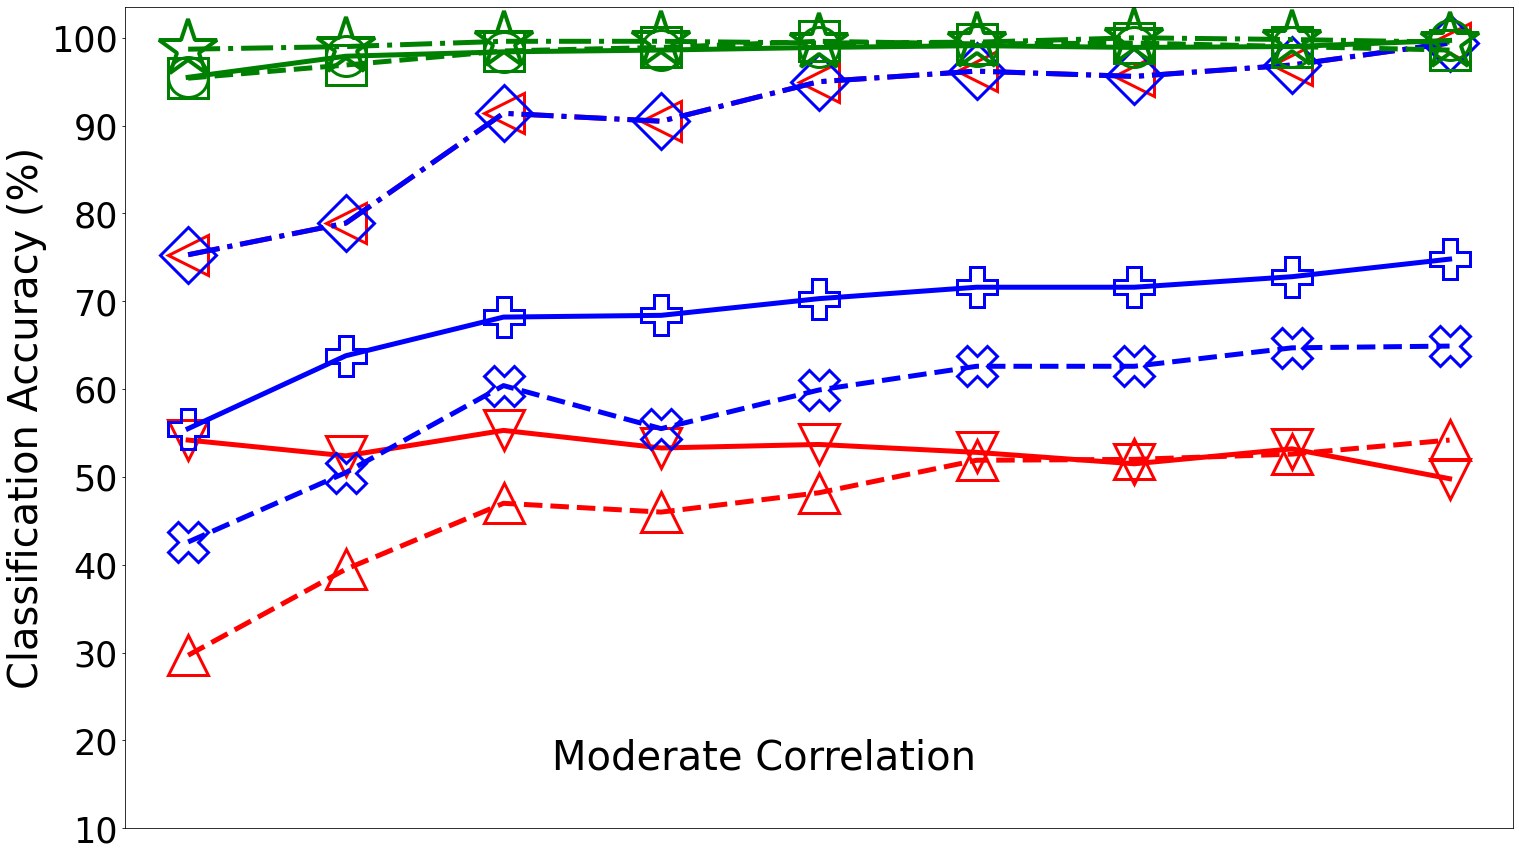

In [18]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(20,12))
fig.tight_layout()


labels = ["Org_Mean: Only Accl", "Org_Mean: Only Gyro", "Org_Mean: Both Sensors"]
markers = ["-vr","--^r","-.<r"]
for i in range(len(H_combinations)-1):
    y_data = (org_accuracy_record_copy.mean(0))[:,i]*100    
    err = (org_accuracy_record_copy.std(0))[:,i]*100
    x_data = np.array(W_combinations)
    ax.plot(x_data, y_data, markers[i], label=labels[i], markersize= 40, linewidth=5,
            markerfacecolor="None",  markeredgewidth=3)    
    if len(rnd_seeds)>1:
        ax.errorbar(x_data, y_data, err, ecolor="r")    

labels = ["Org_Copy: Only Accl", "Org_Copy: Only Gyro", "Org_Copy: Both Sensors"]
markers = ["-Pb","--Xb","-.Db"]
for i in range(len(H_combinations)-1):
    y_data = (org_accuracy_record_dup.mean(0))[:,i]*100    
    err = (org_accuracy_record_dup.std(0))[:,i]*100    
    x_data = np.array(W_combinations)
    ax.plot(x_data, y_data, markers[i], label=labels[i], markersize= 40, linewidth=5,
            markerfacecolor="None",  markeredgewidth=3)
    if len(rnd_seeds)>1:
        ax.errorbar(x_data, y_data, err, elinewidth= 5, ecolor="b")    

labels = ["DANA: Only Accl", "DANA: Only Gyro", "DANA: Both Sensors"]
markers = ["-og","--sg","-.*g"]
for i in range(len(H_combinations)-1):
    y_data = (accuracy_record.mean(0))[:,i]*100    
    err = (accuracy_record.std(0))[:,i]*100    
    x_data = np.array(W_combinations)
    if i < 2:
        ax.plot(x_data, y_data, markers[i], label=labels[i], markersize= 40, linewidth=5,
            markerfacecolor="None",  markeredgewidth=3)    
    else:
        ax.plot(x_data, y_data, markers[i], label=labels[i], markersize= 60, linewidth=5,
            markerfacecolor="None",  markeredgewidth=4)  
    if len(rnd_seeds)>1:
        ax.errorbar(x_data, y_data, err, elinewidth= 5, ecolor="g")  

fig.text(0.32, .1, "Moderate Correlation", size = 40)    
# ax.set_xticks(x_data)
ax.set_xticks([])
plt.setp(ax.get_xticklabels(), fontsize=35)    
ax.set_yticks(np.arange(10,101,10))
# ax.set_ylim(-20,101)
plt.setp(ax.get_yticklabels(), fontsize=35)

ax.set_ylabel("Classification Accuracy (%)", size = 40)

# fig.text(0.4, -0.05, "Sampling Rate (Hz)", size = 40)
# fig.text(-0.05, 0.5, "Classification Accuracy (%)", va='center', rotation='vertical', size = 40)
# ax.legend(loc= "lower center",prop={'size': 29}, ncol=3, bbox_to_anchor=(.5, .99))
plt.show()

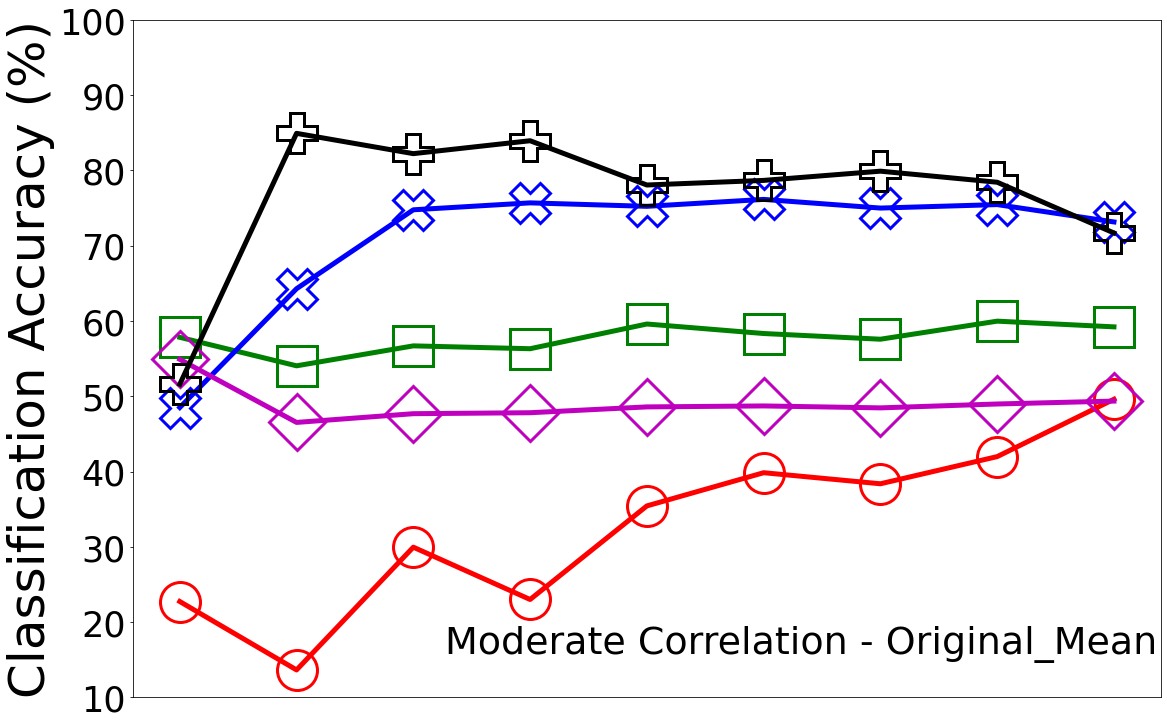

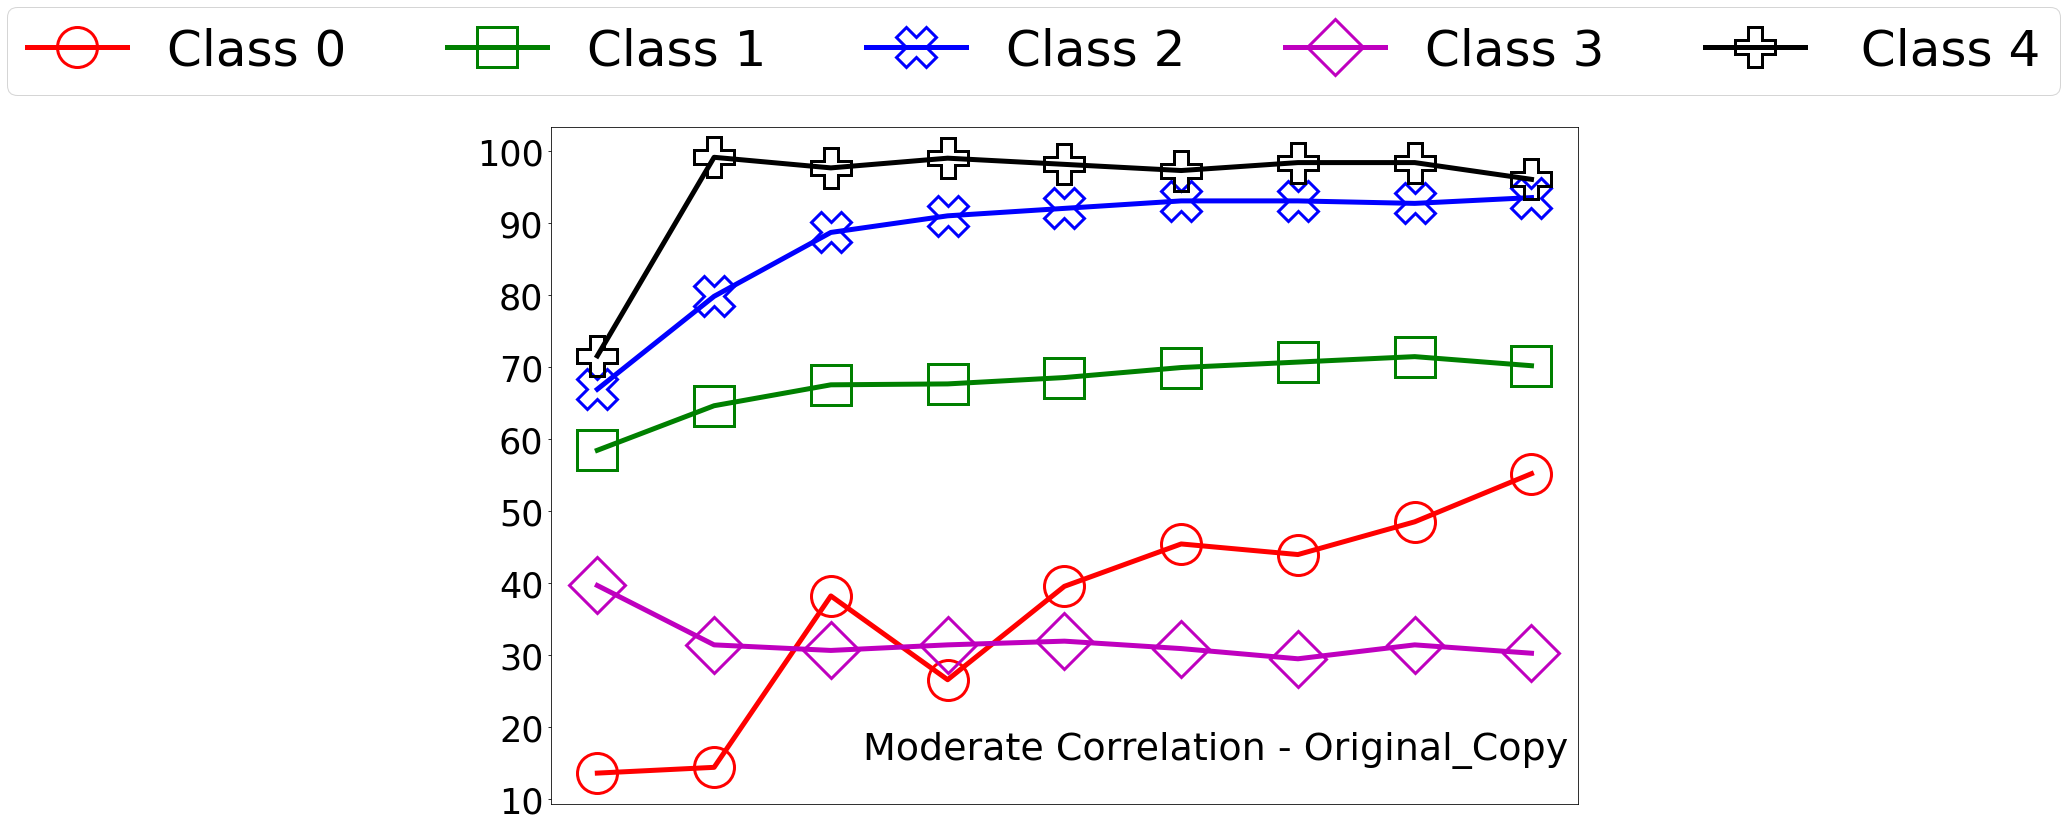

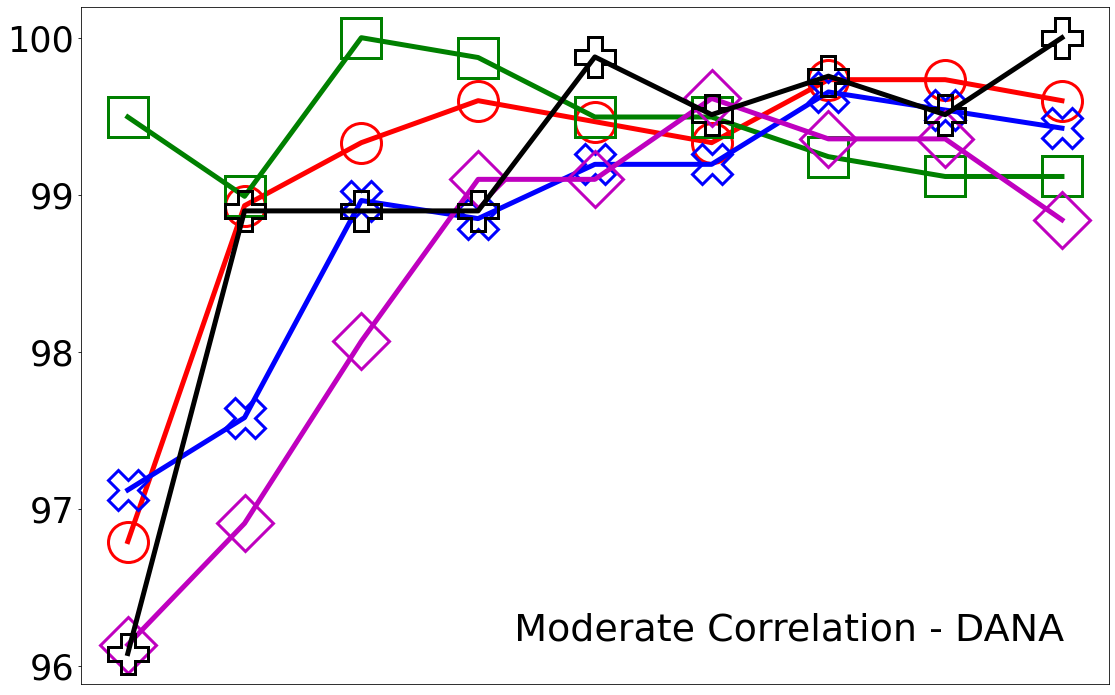

In [19]:
def plot_classes(results, title, x_tick=True, x_lab= True, y_lab=True, leg=True, y_tic=np.arange(10,101,10)):
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(15,10))
    fig.tight_layout()


    labels = ["Class 0", "Class 1", "Class 2", "Class 3"," Class 4"]
    markers = ["-or","-sg","-Xb", "-Dm", "-Pk"]
    for i in range(5):
        y_data = (results.mean((0,2)))[:,i]*100    
        err = (results.std((0,2)))[:,i]*100    
        x_data = np.array(W_combinations)    
        ax.plot(x_data, y_data, markers[i], label=labels[i], markersize= 40, linewidth=5,
                markerfacecolor="None",  markeredgewidth=3)        
         

    if x_tick:
        ax.set_xticks(x_data)
    else:
        ax.set_xticks([])
    plt.setp(ax.get_xticklabels(), fontsize=35)    
    ax.set_yticks(y_tic)
    # ax.set_ylim(-20,101)
    plt.setp(ax.get_yticklabels(), fontsize=35)

    fig.text(0.32, .1, title, size = 38)    
    # if x_lab:
        # fig.text(0.4, -0.05, "Sampling Rate (Hz)", size = 40)
        # ax.set_xlabel("Sampling Rate (Hz)", size = 40)
    if y_lab:
        # fig.text(-0.1, 0.5, "Classification Accuracy (%)", va='center', rotation='vertical', size = 40)
        ax.set_ylabel("Classification Accuracy (%)", size = 50)
    if leg:
        ax.legend(loc= "lower center",prop={'size': 50}, ncol=5, bbox_to_anchor=(.47, 1.01))        
    plt.show()

plot_classes(conf_mat_copy, title="Moderate Correlation - Original_Mean", x_tick=False, x_lab=True, y_lab=True, leg=False)
plot_classes(conf_mat_dup, title="Moderate Correlation - Original_Copy", x_tick=False, x_lab=True, y_lab=False, leg=True)
plot_classes(conf_mat_dana, title="          Moderate Correlation - DANA", x_tick=False, y_lab=False, y_tic=np.arange(96,101,1), leg=False)